In [1]:
import pandas as pd
import numpy as np
from time import time
from pprint import PrettyPrinter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
pp = PrettyPrinter()

/Users/blairthurman/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/blairthurman/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Useful Functions

In [2]:
def model_fit(model, train, target, timed=True, feature_importance=False):
    '''
    This function is for checking performance of a single model. 
    
    Optional plot of feature importance for ensemble methods.
    '''
    # Fit
    if timed:
        start = time()
        passed = time() - start
        print(f'Seconds to start: {passed:.2f}')
    model.fit(train, target)
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')
    
    # CV
    cv_score = cross_validation.cross_val_score(model, train, target, cv=5, scoring='roc_auc')
    print(f'CV Score : Mean - {np.mean(cv_score):.3f} | Std - {np.std(cv_score):.3f} | Min - {np.min(cv_score):.3f} | Max - {np.max(cv_score):.3f}')
    if timed:
        passed = time() - start
        print(f'Seconds to CV: {passed:.2f}')
    
    # Plots feature importance, for ensemble models only
    if feature_importance:
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [3]:
def grid_searcher(model, train, target, parameters={}, cv=4, timed=True):
    '''
    Makes a printout of the AUC score for gridsearched models.
    '''
    if timed:
        start = time()
        passed = time() - start
        print(f'Seconds to start: {passed:.2f}')
    gsearcher = GridSearchCV(
        estimator=model, 
        param_grid=parameters,
        scoring='roc_auc',
        n_jobs=4,
        cv=cv)
    gsearcher.fit(train, target)
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')
    print('Grid Scores: \n')
    pp.pprint(gsearcher.cv_results_)
    print(f'Best Model Parameters: {gsearcher.best_params_}')
    print(f'Best Model Score: {gsearcher.best_score_:.4f}')

In [4]:
def cv_plotter(x, y, title, feature_label):
    '''
    Makes a simple scatter plot
    '''
    plt.scatter(x=x, y=y)
    plt.title(f'{title} AUC over {feature_label}')
    plt.xlabel(feature_label)
    plt.ylabel('AUC Score')

In [8]:
def sampler(train, test, size):
    '''
    Just a hack of a function to quickly sample out data. 
    
    Size: Float, 0.0 - 1.0
        Fraction of data you want returned
    '''
    test_size = 1 - size
    results = train_test_split(train, test, test_size=test_size, random_state=42)
    return results[0], results[2]

# Load

In [9]:
df = pd.read_csv('data/application_train_pca.csv')
train = df[df.columns[2:]]
target = df['target']
df.head()

,sk_id_curr,target,0,1,2,3,4,5,6,7,...,28,29,30,31,32,33,34,35,36,37
0,100002,1,0.311091,-1.332634,-0.399883,-2.000222,0.390812,0.672156,-0.191782,1.242912,...,0.094919,0.108869,-0.097447,0.207195,1.110724,-0.885310,0.271509,0.201748,0.078745,-1.013988
1,100003,0,1.003885,2.295670,-0.859131,-1.410614,0.350578,-0.441695,1.138504,-0.655109,...,0.215964,0.051572,0.488226,-0.041404,-0.785569,1.252293,1.370241,-0.178892,-0.732245,0.653229
2,100004,0,-0.356299,-2.745839,0.603927,-0.145268,2.845680,-0.206305,-1.628813,-0.740097,...,-0.140227,0.215135,-0.424872,0.097197,0.123388,0.143478,0.539556,0.226337,-0.640607,-1.492682
3,100006,0,-0.452229,-0.706371,-1.026894,-1.142946,-0.490824,-0.542183,-0.185623,0.939177,...,0.015248,-0.032642,-0.234938,-0.217559,0.080454,-0.554469,-0.494474,0.734851,-0.315487,0.781315
4,100007,0,0.396743,-0.732436,2.179659,-0.024886,1.154158,2.721180,-2.287210,0.657978,...,0.434943,0.120781,-0.307910,-0.718415,-0.035805,-1.283724,0.026249,0.483156,2.127985,-0.200012


# Modeling

## Gradient Boost

---
### Benchmark

Seconds to start: 0.00
Seconds to fit: 341.69
CV Score : Mean - 0.688 | Std - 0.002 | Min - 0.685 | Max - 0.690
Seconds to CV: 1574.67


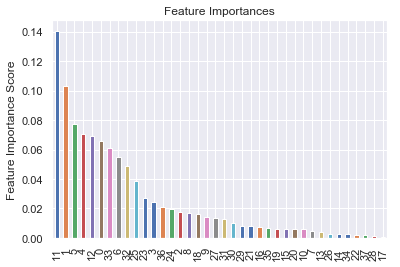

In [10]:
model = GradientBoostingClassifier()

model_fit(model, train, target, feature_importance=True)

Already better than the tuned RFC and on par with the Logistic Regression. Great!

---
### Data

Given that the benchmark GBC took 10 times as long to run as the RFC on the entire dataset, training will be done with just 1/5 of the dataset. 

In [20]:
train_sample, test_sample = sampler(train, target, 1/5)

---
### n_estimators

In [22]:
parameters = {
    'n_estimators': range(20, 101, 10)
}

model = GradientBoostingClassifier(
    max_depth=8,
    min_samples_split=1000,
    min_samples_leaf=50,
    max_features='sqrt',
    subsample=0.8,
    random_state=42
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 184.48
Grid Scores: 

{'mean_fit_time': array([ 6.6726138 , 10.03338277, 12.19777691, 15.25464696, 19.72019446,
       23.42524344, 26.40633118, 27.51865435, 30.1420936 ]),
 'mean_score_time': array([0.03506774, 0.04084814, 0.04758042, 0.06056792, 0.07418454,
       0.07252902, 0.07657021, 0.0883432 , 0.07303065]),
 'mean_test_score': array([0.67549275, 0.67949047, 0.68031151, 0.68113989, 0.68129467,
       0.68080589, 0.68039496, 0.67948176, 0.67842183]),
 'mean_train_score': array([0.77389621, 0.7891711 , 0.80036652, 0.80923874, 0.81785282,
       0.82586588, 0.83375623, 0.84124062, 0.8482547 ]),
 'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80, 90, 100],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object),
 'params': [{'n_estimators': 20},
            {'n_estimators': 30},
            {'n_estimators': 40},
            {'n_estim

In [23]:
parameters = {
    'n_estimators': range(20, 101, 10)
}

model = GradientBoostingClassifier(
    max_depth=8,
    min_samples_split=1000,
    min_samples_leaf=50,
    max_features='sqrt',
    subsample=1.0,
    random_state=42
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 208.91
Grid Scores: 

{'mean_fit_time': array([ 7.46149325, 14.48682624, 15.98760909, 21.70739144, 23.22521317,
       22.29051834, 28.31235528, 28.1848194 , 32.98886693]),
 'mean_score_time': array([0.03726274, 0.07015014, 0.05632186, 0.05573148, 0.06143385,
       0.0680542 , 0.09797198, 0.07959878, 0.07537681]),
 'mean_test_score': array([0.67438772, 0.67707494, 0.678229  , 0.67841903, 0.67876689,
       0.67796927, 0.67761368, 0.67690258, 0.67555737]),
 'mean_train_score': array([0.78973196, 0.80445229, 0.81578195, 0.82461535, 0.83253091,
       0.84069029, 0.84743344, 0.85466373, 0.86067279]),
 'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80, 90, 100],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object),
 'params': [{'n_estimators': 20},
            {'n_estimators': 30},
            {'n_estimators': 40},
            {'n_estim

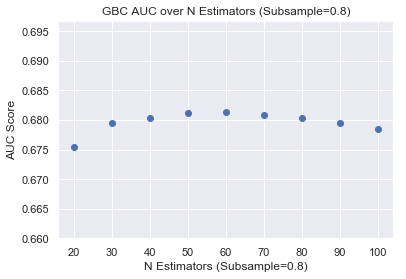

In [24]:
x = range(20, 101, 10)
y = [0.67549275, 0.67949047, 0.68031151, 0.68113989, 0.68129467,
       0.68080589, 0.68039496, 0.67948176, 0.67842183]
cv_plotter(x, y, 'GBC', 'N Estimators (Subsample=0.8)')

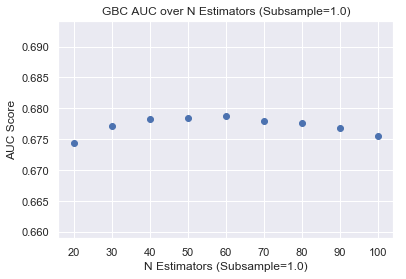

In [25]:
x = range(20, 101, 10)
y = [0.67438772, 0.67707494, 0.678229  , 0.67841903, 0.67876689,
       0.67796927, 0.67761368, 0.67690258, 0.67555737]
cv_plotter(x, y, 'GBC', 'N Estimators (Subsample=1.0)')

60 is the right number of trees

---
### max_depth

In [28]:
parameters = {
    'max_depth': range(4, 13)
}

model = GradientBoostingClassifier(
    n_estimators=60,
    min_samples_split=1000,
    min_samples_leaf=50,
    max_features='sqrt',
    subsample=1.0,
    random_state=42
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 183.92
Grid Scores: 

{'mean_fit_time': array([ 9.58727294, 12.25467122, 16.78121698, 18.83958727, 18.13056719,
       20.78076869, 26.69225276, 27.06796384, 26.06054491]),
 'mean_score_time': array([0.04403484, 0.06668788, 0.05471498, 0.05346423, 0.06364542,
       0.06343603, 0.06651473, 0.06494695, 0.05812991]),
 'mean_test_score': array([0.68249625, 0.68163822, 0.68158804, 0.67955939, 0.67876689,
       0.67761238, 0.67709772, 0.67571128, 0.67485436]),
 'mean_train_score': array([0.74370214, 0.76619999, 0.79007928, 0.81157261, 0.83253091,
       0.84953437, 0.86132509, 0.87633157, 0.88501891]),
 'param_max_depth': masked_array(data=[4, 5, 6, 7, 8, 9, 10, 11, 12],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'max_depth': 7},
            {

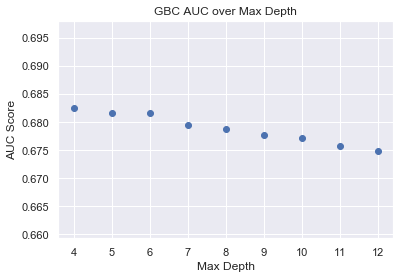

In [29]:
x = range(4, 13)
y = [0.68249625, 0.68163822, 0.68158804, 0.67955939, 0.67876689,
       0.67761238, 0.67709772, 0.67571128, 0.67485436]
cv_plotter(x, y, 'GBC', 'Max Depth')

Going to take 4 here.

---
### min_samples_split

In [30]:
parameters = {
    'min_samples_split': range(800, 1201, 100)
}

model = GradientBoostingClassifier(
    n_estimators=60,
    max_depth=4,
    min_samples_leaf=50,
    max_features='sqrt',
    subsample=1.0,
    random_state=42
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 51.20
Grid Scores: 

{'mean_fit_time': array([8.80845392, 8.37145972, 9.53474027, 8.862849  , 9.60090882]),
 'mean_score_time': array([0.04443854, 0.04586059, 0.04385942, 0.04126662, 0.03234965]),
 'mean_test_score': array([0.6813459 , 0.68167312, 0.68249625, 0.68224321, 0.68224444]),
 'mean_train_score': array([0.74514627, 0.74427743, 0.74370214, 0.74304231, 0.74290517]),
 'param_min_samples_split': masked_array(data=[800, 900, 1000, 1100, 1200],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'min_samples_split': 800},
            {'min_samples_split': 900},
            {'min_samples_split': 1000},
            {'min_samples_split': 1100},
            {'min_samples_split': 1200}],
 'rank_test_score': array([5, 4, 1, 3, 2], dtype=int32),
 'split0_test_score': array([0.68011036, 0.68107663, 0.68178508, 0.67884342, 0.67869625]),
 'split0_train_score': array([0.74711338, 0.7460736 

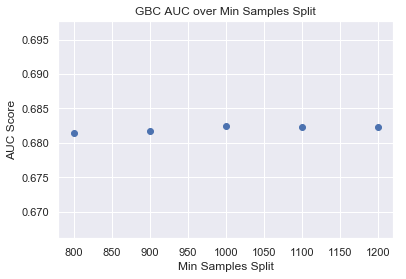

In [31]:
x = range(800, 1201, 100)
y = [0.6813459 , 0.68167312, 0.68249625, 0.68224321, 0.68224444]
cv_plotter(x, y, 'GBC', 'Min Samples Split')

Sticking with 1000 here.

---
### min_samples_leaf

In [32]:
parameters = {
    'min_samples_leaf': range(30, 91, 10)
}

model = GradientBoostingClassifier(
    n_estimators=60,
    max_depth=5,
    min_samples_split=1000,
    max_features='sqrt',
    subsample=1.0,
    random_state=42
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 95.78
Grid Scores: 

{'mean_fit_time': array([13.86074179, 11.87855327, 11.28239638, 11.81280917, 12.36136687,
       13.91664171, 12.46713799]),
 'mean_score_time': array([0.05116922, 0.0485782 , 0.0488677 , 0.04594535, 0.06599122,
       0.04635501, 0.04106444]),
 'mean_test_score': array([0.6831859 , 0.68276547, 0.68163822, 0.68254383, 0.68189533,
       0.68213816, 0.6830424 ]),
 'mean_train_score': array([0.76757962, 0.76686701, 0.76619999, 0.76618452, 0.76716456,
       0.76580971, 0.76590911]),
 'param_min_samples_leaf': masked_array(data=[30, 40, 50, 60, 70, 80, 90],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'min_samples_leaf': 30},
            {'min_samples_leaf': 40},
            {'min_samples_leaf': 50},
            {'min_samples_leaf': 60},
            {'min_samples_leaf': 70},
            {'min_samples_leaf': 80},
            {'min_samples_leaf':

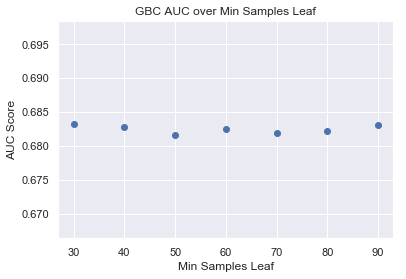

In [33]:
x = range(30, 91, 10)
y = [0.6831859 , 0.68276547, 0.68163822, 0.68254383, 0.68189533,
       0.68213816, 0.6830424]
cv_plotter(x, y, 'GBC', 'Min Samples Leaf')

Could go with 30 or 60. Picking 60.

---
### max_features

In [34]:
parameters = {
    'max_features': range(3, 13)
}

model = GradientBoostingClassifier(
    n_estimators=60,
    max_depth=5,
    min_samples_split=1000,
    min_samples_leaf=60,
    subsample=1.0,
    random_state=42
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 157.42
Grid Scores: 

{'mean_fit_time': array([ 7.57283354,  9.43708712,  9.91733563, 11.47330445, 13.49582839,
       14.1181156 , 16.36116135, 19.56566226, 18.89022112, 22.85659027]),
 'mean_score_time': array([0.06052524, 0.05134892, 0.05004352, 0.05311006, 0.05023521,
       0.04561615, 0.04680037, 0.04785275, 0.04494369, 0.06406206]),
 'mean_test_score': array([0.68171991, 0.68187207, 0.6833368 , 0.68254383, 0.68304553,
       0.68327218, 0.68218381, 0.68222877, 0.68293474, 0.6842246 ]),
 'mean_train_score': array([0.76292421, 0.7645056 , 0.76617823, 0.76618452, 0.76751108,
       0.76906479, 0.76846501, 0.77044201, 0.77023275, 0.7710864 ]),
 'param_max_features': masked_array(data=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_features': 3},
            {'max_features': 4},
     

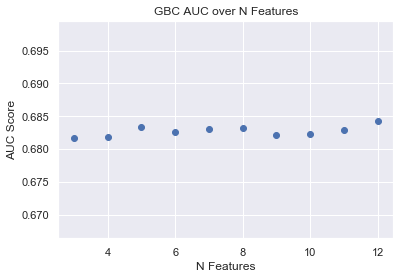

In [35]:
x = range(3, 13)
y = [0.68171991, 0.68187207, 0.6833368 , 0.68254383, 0.68304553,
       0.68327218, 0.68218381, 0.68222877, 0.68293474, 0.6842246]
cv_plotter(x, y, 'GBC', 'N Features')

In [39]:
parameters = {
    'max_features': range(10, 21, 2)
}

model = GradientBoostingClassifier(
    n_estimators=60,
    max_depth=5,
    min_samples_split=1000,
    min_samples_leaf=60,
    subsample=1.0,
    random_state=42
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 187.90
Grid Scores: 

{'mean_fit_time': array([18.75598758, 22.04476583, 28.40508038, 28.92232472, 38.45234835,
       37.91939145]),
 'mean_score_time': array([0.06100523, 0.04601943, 0.04400575, 0.04381502, 0.04912424,
       0.04002309]),
 'mean_test_score': array([0.68222877, 0.6842246 , 0.68419217, 0.68293092, 0.68369928,
       0.68310192]),
 'mean_train_score': array([0.77044201, 0.7710864 , 0.77323669, 0.77161597, 0.77369349,
       0.77395088]),
 'param_max_features': masked_array(data=[10, 12, 14, 16, 18, 20],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_features': 10},
            {'max_features': 12},
            {'max_features': 14},
            {'max_features': 16},
            {'max_features': 18},
            {'max_features': 20}],
 'rank_test_score': array([6, 1, 2, 5, 3, 4], dtype=int32),
 'split0_test_score': array([0.68141076, 0.68406961, 0.684

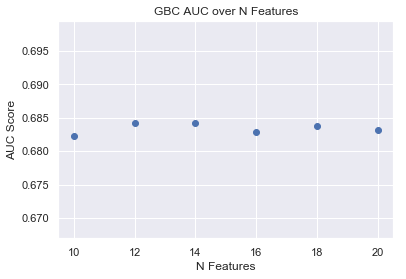

In [41]:
x = range(10, 21, 2)
y = [0.68222877, 0.6842246 , 0.68419217, 0.68293092, 0.68369928,
       0.68310192]
cv_plotter(x, y, 'GBC', 'N Features')

12 it is.

---
### subsample

In [42]:
parameters = {
    'subsample': np.arange(0.1, 1.1, 0.1)
}

model = GradientBoostingClassifier(
    n_estimators=60,
    max_depth=5,
    min_samples_split=1000,
    min_samples_leaf=60,
    max_features=12,
    random_state=42
)

grid_searcher(model, train_sample, test_sample, parameters=parameters)

Seconds to start: 0.00
Seconds to fit: 148.69
Grid Scores: 

{'mean_fit_time': array([ 4.55031353,  8.17226088, 12.75694096, 11.91590971, 12.16626859,
       14.59152478, 16.29578149, 18.0439778 , 20.42172468, 18.8423537 ]),
 'mean_score_time': array([0.04592568, 0.06395978, 0.06848949, 0.04383969, 0.04335552,
       0.04576725, 0.04512799, 0.04428858, 0.04422379, 0.03504503]),
 'mean_test_score': array([0.66911732, 0.67761467, 0.67862811, 0.6802109 , 0.68336669,
       0.68545487, 0.68158252, 0.68248124, 0.68287035, 0.6842246 ]),
 'mean_train_score': array([0.70258025, 0.72281399, 0.73551897, 0.74494864, 0.74973072,
       0.75443679, 0.76087608, 0.76394575, 0.76733899, 0.7710864 ]),
 'param_subsample': masked_array(data=[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                   0.7000000000000001, 0.8, 0.9, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'param

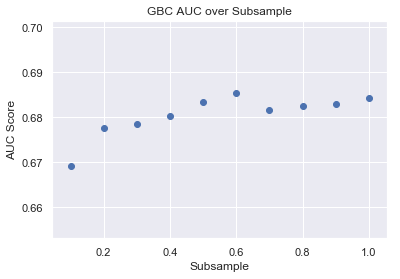

In [43]:
x = np.arange(0.1, 1.1, 0.1)
y = [0.66911732, 0.67761467, 0.67862811, 0.6802109 , 0.68336669,
       0.68545487, 0.68158252, 0.68248124, 0.68287035, 0.6842246]
cv_plotter(x, y, 'GBC', 'Subsample')

0.6, Stochastic it is then.

---
### learning_rate

* n_estimators: 60
* learning_rate: 0.1

Seconds to start: 0.00
Seconds to fit: 7.71
CV Score : Mean - 0.681 | Std - 0.006 | Min - 0.671 | Max - 0.689
Seconds to CV: 36.95


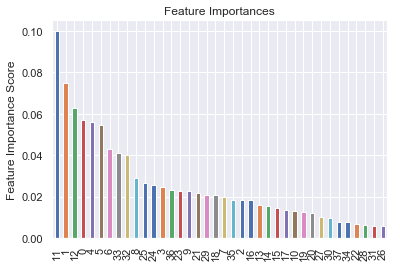

In [44]:
model = GradientBoostingClassifier(
    n_estimators=60,
    max_depth=5,
    min_samples_split=1000,
    min_samples_leaf=60,
    max_features=12,
    subsample=0.6,
    learning_rate=0.1,
    random_state=42
)

model_fit(model, train_sample, test_sample, feature_importance=True)

---
* n_estimators: 120
* learning_rate: 0.05

Seconds to start: 0.00
Seconds to fit: 17.68
CV Score : Mean - 0.686 | Std - 0.006 | Min - 0.678 | Max - 0.692
Seconds to CV: 81.13


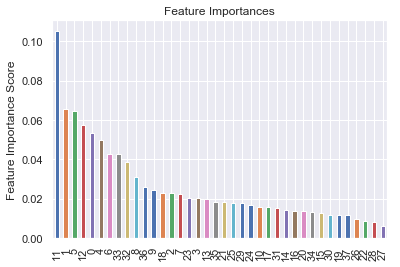

In [45]:
model = GradientBoostingClassifier(
    n_estimators=120,
    max_depth=5,
    min_samples_split=1000,
    min_samples_leaf=60,
    max_features=12,
    subsample=0.6,
    learning_rate=0.05,
    random_state=42
)

model_fit(model, train_sample, test_sample, feature_importance=True)

---
* n_estimators: 200
* learning_rate: 0.03

Seconds to start: 0.00
Seconds to fit: 30.37
CV Score : Mean - 0.687 | Std - 0.006 | Min - 0.680 | Max - 0.695
Seconds to CV: 132.32


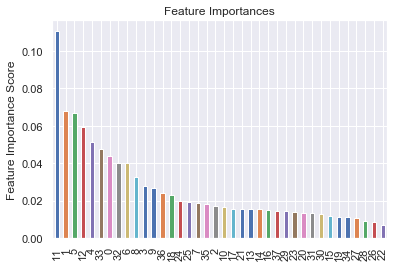

In [48]:
model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=1000,
    min_samples_leaf=60,
    max_features=12,
    subsample=0.6,
    learning_rate=0.03,
    random_state=42
)

model_fit(model, train_sample, test_sample, feature_importance=True)

---
* n_estimators: 300
* learning_rate: 0.02

Seconds to start: 0.00
Seconds to fit: 40.52
CV Score : Mean - 0.688 | Std - 0.005 | Min - 0.682 | Max - 0.696
Seconds to CV: 184.32


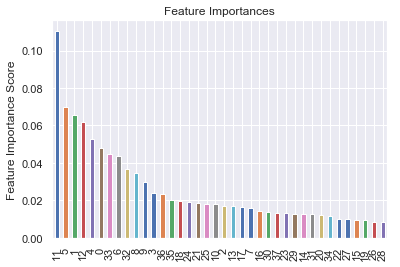

In [46]:
model = GradientBoostingClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_split=1000,
    min_samples_leaf=60,
    max_features=12,
    subsample=0.6,
    learning_rate=0.02,
    random_state=42
)

model_fit(model, train_sample, test_sample, feature_importance=True)

---
* n_estimators: 600
* learning_rate: 0.01

Seconds to start: 0.00
Seconds to fit: 76.26
CV Score : Mean - 0.688 | Std - 0.006 | Min - 0.681 | Max - 0.697
Seconds to CV: 382.01


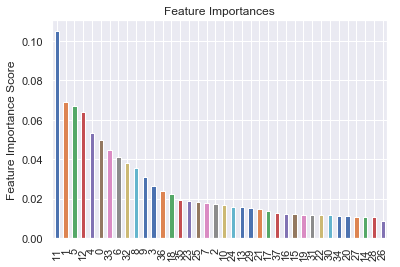

In [47]:
model = GradientBoostingClassifier(
    n_estimators=600,
    max_depth=5,
    min_samples_split=1000,
    min_samples_leaf=60,
    max_features=12,
    subsample=0.6,
    learning_rate=0.01,
    random_state=42
)

model_fit(model, train_sample, test_sample, feature_importance=True)

For training on more data's sake, going with a learning rate of 0.05 and 120 trees for the 0.005 bump in AUC.

---
### Final Model

Seconds to start: 0.00
Seconds to fit: 166.79
CV Score : Mean - 0.690 | Std - 0.002 | Min - 0.688 | Max - 0.693
Seconds to CV: 778.01


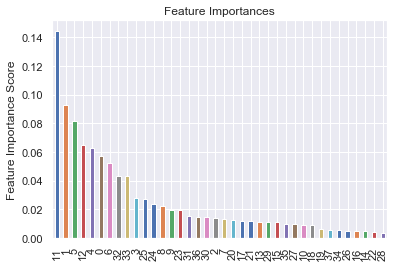

In [49]:
model = GradientBoostingClassifier(
    n_estimators=120,
    max_depth=5,
    min_samples_split=1000,
    min_samples_leaf=60,
    max_features=12,
    subsample=0.6,
    learning_rate=0.05,
    random_state=42
)

model_fit(model, train, target, feature_importance=True)

A whopping 0.002 increase in AUC over Logistic Regression. Neat.

Seconds to start: 0.00
Seconds to fit: 345.43
CV Score : Mean - 0.691 | Std - 0.002 | Min - 0.688 | Max - 0.694
Seconds to CV: 1597.03


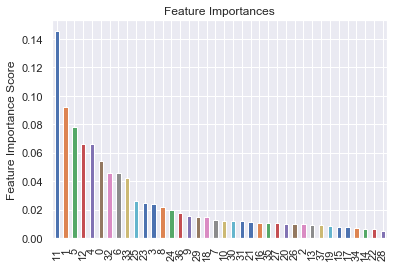

In [50]:
model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=1000,
    min_samples_leaf=60,
    max_features=12,
    subsample=0.6,
    learning_rate=0.03,
    random_state=42
)

model_fit(model, train, target, feature_importance=True)

Well, I suppose a half hour was worth the wait for 0.003 improvement of AUC instead of 0.002. Final model.

Might be worth it to go for 300 trees and 0.02 learning rate later on. Tuning showed a delta of 0.001 AUC available but I don't want to double traiing time for CV right now. Squeezing blood out of a rock by this point though.